In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random as rm
import numpy as np

In [4]:
def f_activations(x):
    # Приведение к (1,0)
    return 1 / ( 1 + np.exp(x) )

def f_act01(x):
    return 1 if x > 0 else 0

def str2int_arr(str):
    return [float(i) for i in str]

def W_init(images):
    W = np.zeros((len(images[0]),len(images[0])))
    for X in images:
        arr_of_int = np.array(str2int_arr(X))
        W += np.outer(arr_of_int, arr_of_int)
    # порог?
    # деление? 
    return W

def energy(X, W):
    n = len(X)
    sum = 0
    for i in range(n):
        for j in range(n):
            sum += W[i][j]*X[i]*X[j]
    
    sum2 = 0
    for i in range(n):
        sum2 += X[i]# *h[i]?
    
    return -0.5*sum + sum2

def random_01(size):
    string = ""
    for _ in range(size):
        string += rm.choice("01")
    return string

def graph_from_file(file):
    w = []
    with open(file, "r") as f:
        for line in f:
            arr = line.split()
            map(float, arr)
            w.append(str2int_arr(arr))
    return nx.from_numpy_matrix(np.array(w))

def graph_from_dimacs(file):
    G = nx.Graph()
    with open(file, "r") as f:
        for line in f:
            buff = line.split()
            if buff[0]=="p":
                G.add_nodes_from([i for i in range(1, int(buff[2])+1 )])
                break
        for line in f:
            edge = line.split()
            G.add_edge(int(edge[1]), int(edge[2]))
    return G


In [15]:
G = graph_from_dimacs("DIMACS_subset_ascii/C125.9.clq")
#w = nx.adjacency_matrix(g).todense()
#l = len(w)

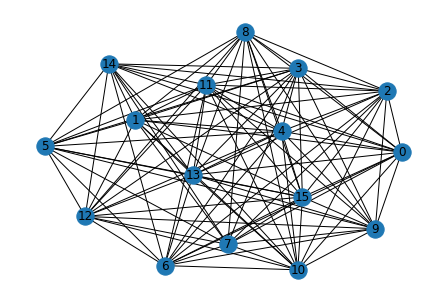

In [72]:
G = graph_from_file("graph_examples/16_9")
nx.draw(G, with_labels=True)

In [26]:
X  = random_01(G.number_of_nodes())
X = np.array(str2int_arr(X))

W = nx.adjacency_matrix(G).todense()

h_i = 3
print(X)

[1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0.]


C:\Users\arkad\AppData\Local\Temp\ipykernel_9084\495536525.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(G).todense()


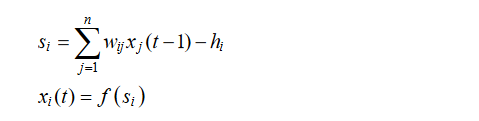

In [27]:
iteration = 0
iter_no_change = 0
while(True): #do{} while() loop
    iteration += 1
    
    i = rm.randint(0, G.number_of_nodes()-1)  # num_update
    X_next = 0
    for j in range(G.number_of_nodes()):
        X_next += W[i, j]*X[j]
    X_next = f_activations(X_next - h_i)
    
    if X[i] == X_next:
        iter_no_change += 1
    else:
        iter_no_change = 0
        X[i] = X_next
        
    if( iter_no_change>=400 or iteration > 100000 ): # изменяемо
        break
    
    
print(X, iteration, sep="\n")

[0.05066239 0.05036968 0.06693713 0.04938436 0.05106086 0.04510488
 0.03840869 0.03632489 0.04898492 0.04392881 0.0408777  0.0611871
 0.05049547 0.06221647 0.06898497 0.06734611 0.06646176 0.03965654
 0.03797756 0.05157535 0.0554144  0.04314666 0.05130149 0.04173249
 0.04881078 0.05292316 0.04957992 0.05690612 0.04079126 0.04765573
 0.05018763 0.05906472 0.0664266  0.04612162 0.05307278 0.101787
 0.05131668 0.06034603 0.0410459  0.04077647 0.04493331 0.07317312
 0.05165801 0.04893502 0.03616851 0.04645101 0.04200869 0.04749631
 0.03834672 0.06408697 0.08232932 0.04584746 0.0518761  0.03279291
 0.05995157 0.05796049 0.04772505 0.04822074 0.04331235 0.03381708
 0.05746386 0.05175124 0.06240244 0.06710478 0.04164744 0.05490493
 0.03991773 0.06767065 0.051684   0.04055016 0.06151052 0.0511766
 0.07884489 0.04696036 0.08878709 0.07576136 0.04597592 0.05892578
 0.05749578 0.03884196 0.0650859  0.04600346 0.08465394 0.05175439
 0.04828262 0.04898698 0.0548881  0.07387024 0.06309651 0.07943628